<h2 style="color:darkred;font-size:25px">Projet 6 : Classifiez automatiquement des biens de consommation</h2>

<img src="support\logo.png" style="width: 350px;"/>

<h2 style="color:darkred;font-size:25px">Notebook 4 : Computer Vision via Transfer Learning</h2>

---
---
---

<h2 style="color:darkred;font-size:20px">Sommaire</h2>

### Téléchargement du jeux de données

In [34]:
# les libraries nécessaires :

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud

In [35]:
# quelques arrangements pour jupyter

# pour voir toutes les colonnes
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)

# style de titres
font = {'family': 'Arial',
        'color':  'darkred',
        'weight': 'bold',
        'size': 15,
        }

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P6/data/flipkart_com-ecommerce_sample_1050.csv')
# data = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')

### Ajout de la catégorie principale :

In [38]:
data['categorie_1'] = data['product_category_tree'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()

# 3. Préparation d'ensemble des images

In [39]:
from os import listdir

path = "/content/drive/MyDrive/Colab Notebooks/P6/images/"
list_photos = data['image'].tolist()
list_photos_as_folder = [file for file in listdir(path)]
print(len(list_photos_as_folder))

1050


# Transfer Learning

## Le modèle VGG16

In [40]:
# Transfer learning en utilisant le modèle VGG16

from tensorflow.keras import applications, layers
from tensorflow.keras import Input, Model

vgg16 = applications.vgg16.VGG16

base_model = vgg16(include_top=False, weights='imagenet', input_shape=(300, 300, 3))

# On gèle les couches inférieures du modèle
for layer in base_model.layers:
    layer.trainable = False    

# Ajout d'un nouveau classifier
flat1 = base_model.layers[-1].output
x = layers.GlobalAveragePooling2D()(flat1)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)
output_img = layers.Dense(7, activation='softmax')(x)

model_img = Model(inputs=base_model.inputs, outputs=output_img)

model_img.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [41]:
model_img.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
from tensorflow.keras import preprocessing

def PreprocessingImg(path='/content/drive/MyDrive/Colab Notebooks/P6/images', list_img= list(data.image)) :
#def PreprocessingImg(path='images', list_img= list(data.image)) :
  ### Fonction effectuant le preprocessing nécessaire sur les images ###
  array_img = []

  for img in list_img:
    image = preprocessing.image.load_img(path+ '/' +img, grayscale=False, color_mode="rgb", target_size=[300,300], interpolation="nearest")
    array = preprocessing.image.img_to_array(image)
    array_img.append(array)
  return np.array([array_img])

img_data = PreprocessingImg()

img_array = img_data[0]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [43]:
from sklearn.model_selection import train_test_split

y = data['categorie_1'].astype('category').cat.codes
X_train_img, X_test_img, y_train_img, y_test_img =train_test_split(img_array, y, test_size=0.2, shuffle=True, random_state=0, stratify=y)

In [44]:
# Entraînement du modèle

history_img = model_img.fit(x=X_train_img, y=y_train_img, epochs=15, validation_split=0.2, shuffle=True, verbose=2)

Epoch 1/15
21/21 - 13s - loss: 4.8840 - accuracy: 0.5164 - val_loss: 1.4424 - val_accuracy: 0.7083 - 13s/epoch - 608ms/step
Epoch 2/15
21/21 - 11s - loss: 0.9024 - accuracy: 0.7932 - val_loss: 0.9659 - val_accuracy: 0.7857 - 11s/epoch - 540ms/step
Epoch 3/15
21/21 - 11s - loss: 0.4348 - accuracy: 0.8542 - val_loss: 0.8855 - val_accuracy: 0.7976 - 11s/epoch - 546ms/step
Epoch 4/15
21/21 - 12s - loss: 0.2403 - accuracy: 0.9211 - val_loss: 0.8988 - val_accuracy: 0.8155 - 12s/epoch - 548ms/step
Epoch 5/15
21/21 - 11s - loss: 0.1920 - accuracy: 0.9330 - val_loss: 0.8626 - val_accuracy: 0.8274 - 11s/epoch - 545ms/step
Epoch 6/15
21/21 - 11s - loss: 0.1236 - accuracy: 0.9613 - val_loss: 1.1083 - val_accuracy: 0.7857 - 11s/epoch - 542ms/step
Epoch 7/15
21/21 - 12s - loss: 0.0975 - accuracy: 0.9702 - val_loss: 0.9901 - val_accuracy: 0.8512 - 12s/epoch - 549ms/step
Epoch 8/15
21/21 - 11s - loss: 0.0808 - accuracy: 0.9702 - val_loss: 0.9582 - val_accuracy: 0.8512 - 11s/epoch - 544ms/step
Epoch 9/

In [45]:
def PlotModel(history=history_img, metric='acc', metric_val='val_acc', loss='loss',
              val_loss='val_loss'):  
  ### Graphique des résultats de l'entraînement ###
  plt.plot(history.history[metric])
  plt.plot(history.history[metric_val])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(history.history[loss])
  plt.plot(history.history[val_loss])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

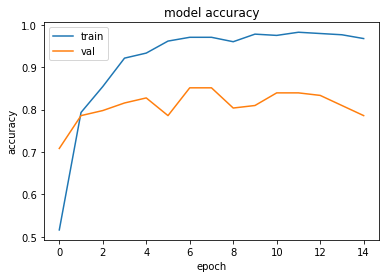

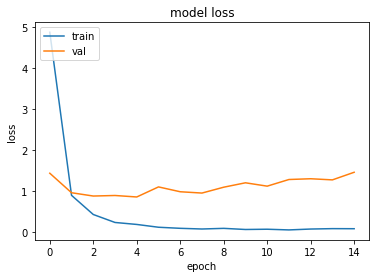

In [46]:
# Visualisation des graphiques d'entraînement du modèle

PlotModel(history=history_img, metric='accuracy', metric_val='val_accuracy', loss='loss',
              val_loss='val_loss')

In [47]:
# Évalutation du modèle sur des nouvelles données 

model_img.evaluate(x=X_test_img, y=y_test_img, batch_size=32, verbose=2)

7/7 - 3s - loss: 1.2948 - accuracy: 0.8095 - 3s/epoch - 449ms/step


[1.2948373556137085, 0.8095238208770752]

In [48]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip

data_augmentation = Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

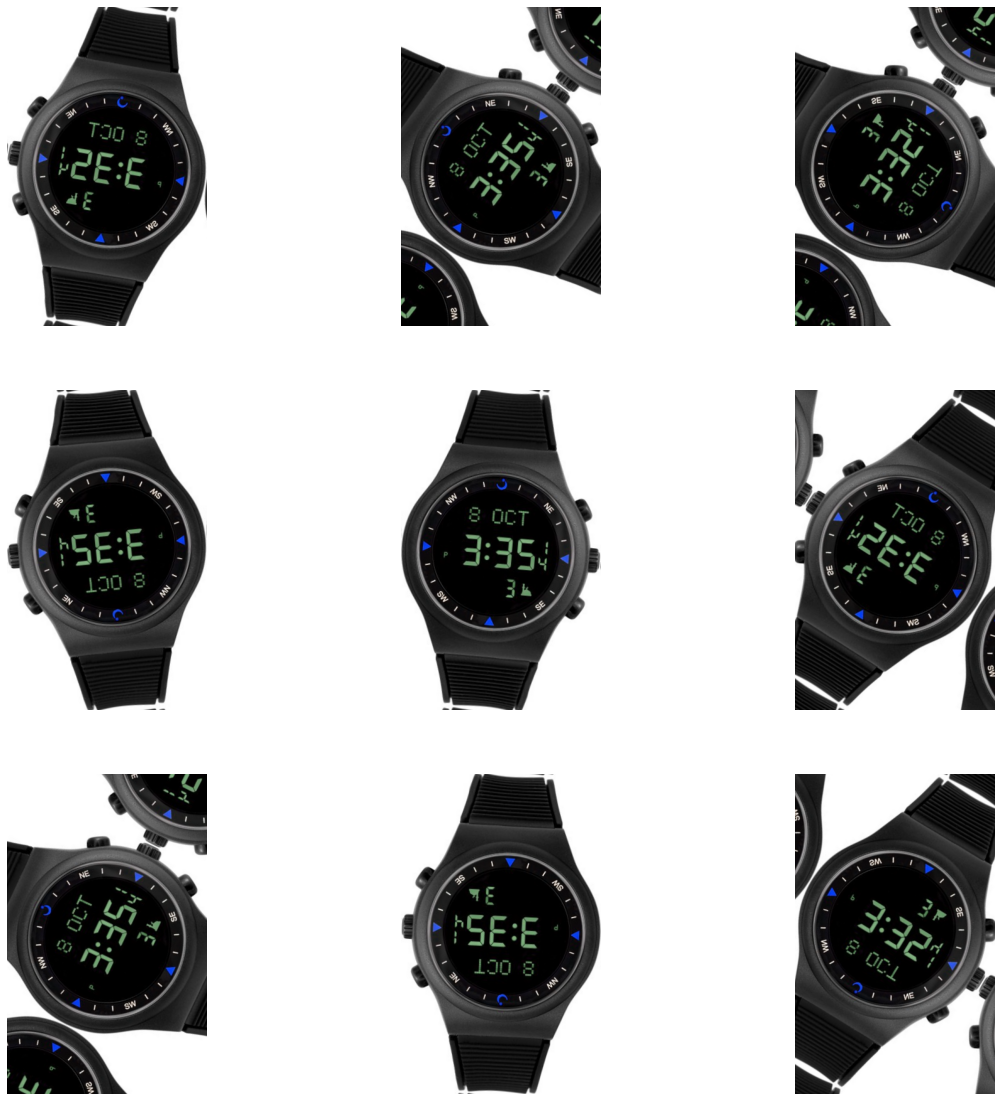

In [49]:
import cv2
import tensorflow as tf

image = cv2.imread(path + '41384da51732c0b4df3de8f395714fbb.jpg')

image = tf.expand_dims(image, 0)
plt.figure(figsize=(20, 20))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")